## COEXP

This notebook tries to explore the Coexp feature in Detail, in order to optimize it for predicting transporters in A thaliana.


# Imports, globals

In [2]:
import os
import sys

# from sklearnex import patch_sklearn
# patch_sklearn()
sys.path.append('../../src')
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, LeaveOneOut, cross_validate, cross_val_predict

import matplotlib.pyplot as plt

from yellowbrick.features import ParallelCoordinates
from yellowbrick.features import Rank1D, Rank2D

import pandas as pd
import numpy as np
import seaborn as sns

from util.fasta import read_fasta
from dataset.transporter_dataset import create_dataset
from dataset.cluster_fasta import cd_hit
from features.labels import fasta_to_labels
from features.compositions import calculate_composition_feature
from features.pssm import calculate_pssm_feature
from features.coexp import calculate_coexp_feature
from models.eval import nested_crossval
from visualization.feature_plots import create_plot

In [4]:
LOG_FILE = "../../logs/athaliana_amino_sugar.log"
N_THREADS = 16
IDENTITY_THRESHOLD=70

# Dataset

In [5]:
# Delete previous log
if os.path.exists(LOG_FILE):
    with open(LOG_FILE, "w"):
        pass

create_dataset(
    keywords_substrate_filter=["Amino-acid transport", "Sugar transport"],
    keywords_component_filter=["Membrane"],
    keywords_transport_filter=["Transport"],
    input_file="../../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate="remove",
    outliers=["O81775", "Q9SW07", "Q9FHH5", "Q8S8A0", "Q3E965", "Q3EAV6", "Q3E8L0"],
    verbose=True,
    tax_ids_filter=[3702],
    output_tsv="../../data/datasets/athaliana_amino_sugar.tsv",
    output_fasta="../../data/datasets/athaliana_amino_sugar.fasta",
    output_log=LOG_FILE,
)

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,sequence
Uniprot,,,,,,,,
Q9SFG0,Sugar transport,Membrane;Transmembrane,Symport;Transport,STP6 At3g05960 F2O10.8,Sugar transport protein 6 (Hexose transporter 6),2.A.1.1.56,3702,MAVVVSNANAPAFEAKMTVYVFICVMIAAVGGLIFGYDIGISGGVS...
Q9ZVK6,Sugar transport,Cell membrane;Membrane;Transmembrane,Symport;Transport,SUC8 At2g14670 T6B13.9,Sucrose transport protein SUC8 (Sucrose permea...,NaN,3702,MSDLQAKNDVVAVDRQSSSSLADLDGPSPLRKMISVASIAAGIQFG...
Q84WN3,Sugar transport,Membrane;Transmembrane,Transport,SWEET17 At4g15920 dl4000c FCAALL.237,Bidirectional sugar transporter SWEET17 (AtSWE...,NaN,3702,MAEASFYIGVIGNVISVLVFLSPVETFWKIVKRRSTEEYKSLPYIC...
O04249,Sugar transport,Cell membrane;Membrane;Transmembrane,Symport;Transport,STP7 At4g02050 AGAA.1 T10M13.6,Sugar transport protein 7 (Hexose transporter 7),NaN,3702,MAGGSFGPTGVAKERAEQYQGKVTSYVIIACLVAAIGGSIFGYDIG...
Q56ZZ7,Sugar transport,Membrane;Plastid inner membrane;Transmembrane,Transport,At5g16150 T21H19.70,Plastidic glucose transporter 4 (AtpGlcT),2.A.1.1.102,3702,MQSSTYAVKGNAAFAFQRRTFSSDRSTTSTGIRFAGYKSLATTGPL...
...,...,...,...,...,...,...,...,...
Q94EI9,Sugar transport,Membrane;Transmembrane,Transport,At3g14410 MLN21.19,Probable sugar phosphate/phosphate translocato...,NaN,3702,MADRSKGFMRAEFVTYAYILLYIALSSGQIFFNKWVLSSKEINFPY...
Q8L6Z8,Sugar transport,Membrane;Transmembrane,Transport,At3g03090 T17B22.22,D-xylose-proton symporter-like 1,2.A.1.1.45,3702,MGFDPENQSISSVGQVVGDSSSGGITAEKEPLLKENHSPENYSVLA...
Q9FDZ5,Sugar transport,Membrane;Transmembrane,Antiport;Transport,URGT6 At1g34020 F12G12.16 T15K4.8,UDP-rhamnose/UDP-galactose transporter 6 (UDP-...,NaN,3702,MAPVSKADKKAAVDAAAWMFNVVTSVGIIIVNKALMATYGYSFATT...


In [6]:
cd_hit(
    executable_location="cd-hit",
    input_fasta=f"../../data/datasets/athaliana_amino_sugar.fasta",
    output_fasta=f"../../data/datasets/athaliana_amino_sugar_cluster{IDENTITY_THRESHOLD}.fasta",
    log_file=LOG_FILE,
    identity_threshold=IDENTITY_THRESHOLD,
    n_threads=N_THREADS,
    memory=4096,
    verbose=True,
)

# Datasets

 TODO here!

In [5]:
# Expression

In [6]:
# Gene Positions

In [7]:
# Neighbors & Coexpression

In [8]:
# GO terms

# Feature generation

TODO put this in script, call script

In [7]:
from scipy.stats import pearsonr


class Coexp:
    #################
    # Preprocessing #
    #################

    def __init__(
        self,
        expression_tsv: str,
        go_tsv: str,
        gene_pos_tsv: str,
        swissprot_tsv: str,
        chromosomes: list,
        tax_id: int,
        n_neighbors: int,
    ):
        df_exp, df_go_long, df_gene_pos_long = self.__read_tables(
            expression_tsv, go_tsv, gene_pos_tsv, chromosomes
        )

        proteins_swissprot = self.__get_swissprot_proteins(
            swissprot_tsv=swissprot_tsv, tax_id=tax_id
        )

        (
            df_exp,
            df_go_long,
            df_gene_pos_long,
            proteins_enough_data,
        ) = self.__filter_datasets(
            df_exp, df_go_long, df_gene_pos_long, proteins_swissprot
        )
        df_neighbors_long = self.__get_neighbors(
            df_gene_pos_long=df_gene_pos_long, n_neighbors=n_neighbors
        )

        self.__proteins_whitelist = proteins_enough_data
        self.__df_exp = df_exp
        self.__df_go_long = df_go_long
        self.__df_neighbors = df_neighbors_long

    def __read_tables(
        self, expression_tsv: str, go_tsv: str, gene_pos_tsv: str, chromosomes: list
    ):
        df_exp = pd.read_table(expression_tsv, index_col=0)
        df_go_long = pd.read_table(go_tsv)
        df_gene_pos_long = pd.read_table(gene_pos_tsv).sort_values(
            ["chr", "start", "strand"]
        )
        df_gene_pos_long = df_gene_pos_long[df_gene_pos_long.chr.isin(chromosomes)]
        return df_exp, df_go_long, df_gene_pos_long

    def __get_swissprot_proteins(self, swissprot_tsv: str, tax_id: int):
        df_swissprot = pd.read_table(
            swissprot_tsv,
            index_col=0,
            usecols=["Entry", "Organism ID", "Protein existence", "Fragment"],
        )
        df_swissprot_filtered = df_swissprot.copy()
        df_swissprot_filtered = df_swissprot_filtered[
            (df_swissprot_filtered["Organism ID"] == tax_id)
        ]
        df_swissprot_filtered = df_swissprot_filtered[
            ~df_swissprot_filtered["Protein existence"].isin(["Predicted", "Uncertain"])
        ]
        df_swissprot_filtered = df_swissprot_filtered[
            df_swissprot_filtered.Fragment.isnull()
        ]
        return df_swissprot_filtered.index.values

    def __filter_datasets(
        self,
        df_exp: pd.DataFrame,
        df_go_long: pd.DataFrame,
        df_gene_pos_long: pd.DataFrame,
        proteins_swissprot,
    ):
        proteins_enough_data = (
            set(proteins_swissprot)
            & set(df_exp.index)
            & set(df_go_long.Uniprot)
            & set(df_gene_pos_long.Uniprot)
        )
        df_exp = df_exp[df_exp.index.isin(proteins_enough_data)]
        df_gene_pos_long = df_gene_pos_long[
            df_gene_pos_long.Uniprot.isin(proteins_enough_data)
        ].reset_index(drop=True)
        df_go_long = df_go_long[
            df_go_long.Uniprot.isin(proteins_enough_data)
        ].reset_index(drop=True)
        return df_exp, df_go_long, df_gene_pos_long, proteins_enough_data

    def __get_neighbors(
        self, df_gene_pos_long: pd.DataFrame, n_neighbors: int
    ) -> pd.DataFrame:
        records_neighbors = []

        for chromosome in df_gene_pos_long.chr.unique():
            df_chr = df_gene_pos_long[df_gene_pos_long.chr == chromosome].reset_index(
                drop=True
            )
            for idx in df_chr.index:
                accession = df_chr.at[idx, "Uniprot"]
                idx_shifted = max(idx, n_neighbors)
                idx_shifted = min(idx_shifted, df_chr.shape[0] - 1 - n_neighbors)
                neighbors = df_chr.iloc[
                    idx_shifted - n_neighbors : idx_shifted + 1 + n_neighbors
                ].Uniprot
                neighbors = neighbors[neighbors != accession]
                for neighbor in neighbors:
                    records_neighbors.append([accession, neighbor, chromosome])
        df_neighbors_long = pd.DataFrame(
            records_neighbors, columns=["Uniprot", "Neighbor", "Chromosome"]
        )
        return df_neighbors_long

    #################
    # Calculation   #
    #################

    def __get_go_profiles(self, df_training: pd.DataFrame) -> dict:
        go_profiles = {}
        for name, df_substrate in df_training.groupby("Label"):
            label = name.replace(" ", "_")
            transporters = df_substrate.Uniprot.unique()
            neighbors = df_substrate.Neighbor.unique()

            go_profiles[label + "_transporters"] = self.__df_go_long[
                self.__df_go_long.Uniprot.isin(transporters)
            ].go_id.unique()
            go_profiles[label + "_neighbors"] = self.__df_go_long[
                self.__df_go_long.Uniprot.isin(neighbors)
            ].go_id.unique()
        return go_profiles

    def get_selected_neighbors(self, accession: str, n_selected: int) -> pd.DataFrame:
        accession_selected_neighbors = self.__df_neighbors[
            self.__df_neighbors.Uniprot == accession
        ]
        accession_selected_neighbors = accession_selected_neighbors.drop_duplicates()
        accession_selected_neighbors = accession_selected_neighbors.assign(
            coexp=accession_selected_neighbors.apply(
                lambda row: pearsonr(
                    self.__df_exp.loc[row.Uniprot], self.__df_exp.loc[row.Neighbor]
                )[0],
                axis=1,
            )
        )

        accession_selected_neighbors = accession_selected_neighbors.sort_values(
            "coexp", ascending=False
        ).iloc[:n_selected]

        accession_selected_neighbors_go = (
            accession_selected_neighbors[["Neighbor", "coexp"]]
            .merge(
                self.__df_go_long, how="left", left_on="Neighbor", right_on="Uniprot"
            )
            .drop(["Uniprot", "coexp"], axis=1)
            .drop_duplicates()
        )

        selected_neighbors_wide = (
            accession_selected_neighbors_go.groupby("Neighbor").apply(
                lambda df_neighbor: df_neighbor.go_id.unique()
            )
            # .sort_index()
        )
        return selected_neighbors_wide

    def __get_percentages(
        self, go_profiles: dict, selected_neighbors_go: pd.DataFrame
    ) -> pd.DataFrame:
        records = []
        for label, profile in sorted(go_profiles.items()):
            i = 0
            for neighbor, neighbor_go in selected_neighbors_go.iteritems():
                percentage = (
                    neighbor_go[np.isin(neighbor_go, profile)].size / neighbor_go.size
                )
                records.append([f"{label}_{i}", neighbor, percentage])
                i += 1
        df_percentages = pd.DataFrame.from_records(
            records, columns=["profile", "neighbor", "percentage"]
        )
        return df_percentages

    def __check_inputs(
        self, accession, training_accessions, training_labels, n_selected
    ):
        assert training_accessions.size == training_labels.size
        assert accession not in training_accessions
        assert isinstance(accession, str)
        assert isinstance(training_accessions, np.ndarray)
        assert isinstance(training_labels, np.ndarray)
        assert isinstance(n_selected, int)


    def __percentage_to_aggregate(self, df_percentages: pd.DataFrame) -> pd.Series:
        df_percentages.profile = (
            df_percentages.profile.str.split("_")
            .str[:3]
            .transform(lambda x: "_".join(x))
        )
        df_percentages = df_percentages.groupby("profile").percentage.max()
        df_percentages = df_percentages.reset_index()
        return df_percentages

    def get_feature(
        self,
        accession: str,
        training_accessions: np.ndarray,
        training_labels: np.ndarray,
        n_selected: int,
        threshold: float,
        # method: str = "binary",
        aggregate: bool = False,
        binary: bool = True,
    ):
        self.__check_inputs(accession, training_accessions, training_labels, n_selected)
        if accession not in self.__proteins_whitelist:
            return None
        df_training = pd.DataFrame(training_accessions, columns=["Uniprot"])
        df_training["Label"] = training_labels

        df_training = df_training.merge(self.__df_neighbors, on="Uniprot", how="left")
        df_training = df_training[~df_training.Neighbor.isnull()].reset_index(drop=True)

        go_profiles = self.__get_go_profiles(df_training)

        selected_neighbors_go = self.get_selected_neighbors(accession, n_selected)
        df_percentages = self.__get_percentages(
            go_profiles=go_profiles, selected_neighbors_go=selected_neighbors_go
        )

        if aggregate:
            df_percentages = self.__percentage_to_aggregate(df_percentages)
        if binary:
            df_percentages["percentage"] = np.where(df_percentages.percentage > threshold, 1, 0)

        df_percentages = df_percentages.set_index("profile", verify_integrity=True)
        result = df_percentages.percentage.rename(accession)
        
        return result

    def get_features(
        self,
        training_accessions: np.ndarray,
        training_labels: np.ndarray,
        n_selected: int,
        threshold: float,
        aggregate: bool = False,
        binary: bool = True,
    ):
        res = []
        for accession in training_accessions:
            mask = training_accessions != accession
            accessions_subset = training_accessions[mask]
            labels_subset = training_labels[mask]

            feature = self.get_feature(
                accession=accession,
                training_accessions=accessions_subset,
                training_labels=labels_subset,
                n_selected=n_selected,
                threshold=threshold,
                aggregate=aggregate,
                binary=binary
            )
            if isinstance(feature, pd.Series):
                res.append(feature)
        res = pd.concat(res, axis=1).transpose()
        return res



In [8]:
coexp5 = Coexp(
    expression_tsv="../data/intermediate/gene_expression/athaliana/athaliana_columbia_flower.tsv",
    go_tsv="../data/intermediate/gene_ontology/goa_athaliana.tsv",
    gene_pos_tsv="../data/intermediate/gene_positions/gene_positions_athaliana.tsv",
    swissprot_tsv="../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    chromosomes=[str(i) for i in [1, 2, 3, 4, 5]],
    tax_id=3702,
    n_neighbors=5
)
coexp10 = Coexp(
    expression_tsv="../data/intermediate/gene_expression/athaliana/athaliana_columbia_flower.tsv",
    go_tsv="../data/intermediate/gene_ontology/goa_athaliana.tsv",
    gene_pos_tsv="../data/intermediate/gene_positions/gene_positions_athaliana.tsv",
    swissprot_tsv="../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    chromosomes=[str(i) for i in [1, 2, 3, 4, 5]],
    tax_id=3702,
    n_neighbors=10
)
coexp20 = Coexp(
    expression_tsv="../data/intermediate/gene_expression/athaliana/athaliana_columbia_flower.tsv",
    go_tsv="../data/intermediate/gene_ontology/goa_athaliana.tsv",
    gene_pos_tsv="../data/intermediate/gene_positions/gene_positions_athaliana.tsv",
    swissprot_tsv="../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    chromosomes=[str(i) for i in [1, 2, 3, 4, 5]],
    tax_id=3702,
    n_neighbors=20
)

FileNotFoundError: [Errno 2] No such file or directory: '../data/intermediate/gene_expression/athaliana/athaliana_columbia_flower.tsv'

In [11]:
def get_training_data(fasta_file: str):
    fasta_data = read_fasta(fasta_file_name=fasta_file)
    fasta_data = [header.split("|")[1:] + [sequence] for header, sequence in fasta_data]
    df_training = pd.DataFrame.from_records(
        fasta_data,
        columns=[
            "Uniprot",
            "Symbols",
            "Taxid",
            "TCDB",
            "Substrate",
            "Description",
            "Sequence",
        ],
        exclude=["Symbols", "Taxid", "TCDB", "Description", "Sequence"],
    )
    return df_training

df_training = get_training_data(fasta_file=f"../data/datasets/athaliana_amino_sugar_cluster{IDENTITY_THRESHOLD}.fasta")

df_training


,Uniprot,Substrate
0,Q9SFG0,Sugar transport
1,Q84WN3,Sugar transport
2,O04249,Sugar transport
3,Q56ZZ7,Sugar transport
4,Q8H184,Sugar transport
...,...,...
112,Q94B65,Sugar transport
113,Q0WWW9,Sugar transport
114,Q2V4B9,Sugar transport
115,Q94EI9,Sugar transport


In [12]:
accession = "Q9LUE3"
accession_label = df_training.loc[df_training.Uniprot == accession].Substrate.values
print(accession_label)
training_df = df_training[df_training.Uniprot != accession]
training_accessions = training_df.Uniprot.values
training_labels = training_df.Substrate.values

result = coexp5.get_feature(
    accession=accession,
    training_accessions=training_accessions,
    training_labels=training_labels,
    # n_neighbors=5,
    n_selected=3,
    threshold=0.8,
    aggregate=True,
    binary=False,
)
result

['Sugar transport']


profile
Amino-acid_transport_neighbors       0.833333
Amino-acid_transport_transporters    0.333333
Sugar_transport_neighbors            1.000000
Sugar_transport_transporters         1.000000
Name: Q9LUE3, dtype: float64

## Visualization


- Percentage of selected neighbor GO terms in GO Profile X and Y:
    - Transporters (Sugar/Amino)
    - Transporter Neighbors (Sugar/Amino)
    - Average of transporter and neighbor percentage (Sugar/Amino)


- Idea: Maybe I should filter GO terms somehow, to make the distinction more clear
    - remove predicted go terms
    - filter out go terms with too many/not enough genes

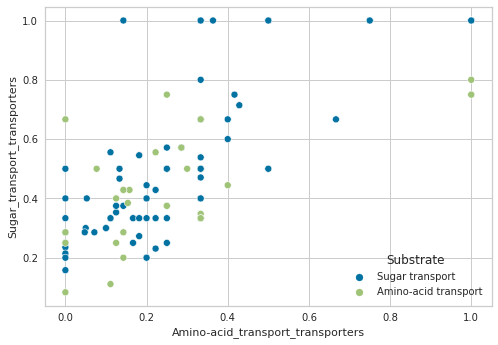

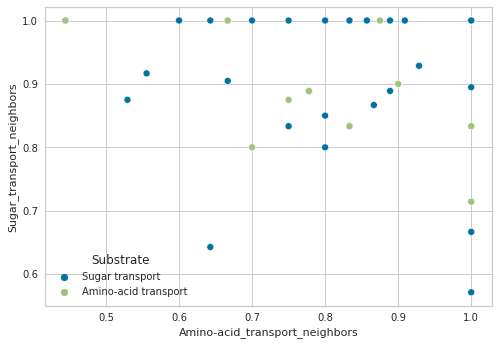

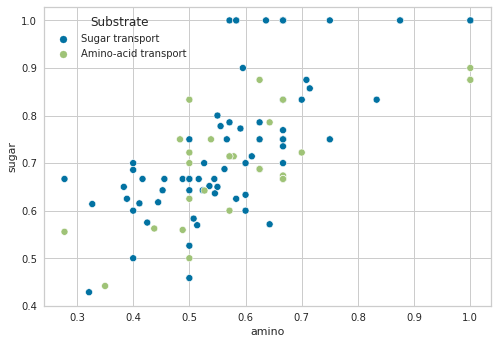

In [13]:
df_coexp_perc = coexp5.get_features(
    training_accessions=df_training.Uniprot.values,
    training_labels=df_training.Substrate.values,
    # n_neighbors=5,
    n_selected=3,
    threshold=0.8,
    aggregate=True,
    binary=False
)

df_coexp_substrate = df_coexp_perc.join(df_training.set_index("Uniprot"), how="left")
df_coexp_substrate["amino"] = (
    df_coexp_substrate["Amino-acid_transport_transporters"]
    + df_coexp_substrate["Amino-acid_transport_neighbors"]
) / 2
df_coexp_substrate["sugar"] = (
    df_coexp_substrate["Sugar_transport_transporters"]
    + df_coexp_substrate["Sugar_transport_neighbors"]
) / 2

sns.scatterplot(
    data=df_coexp_substrate,
    x="Amino-acid_transport_transporters",
    y="Sugar_transport_transporters",
    hue="Substrate",
)
plt.show()
sns.scatterplot(
    data=df_coexp_substrate,
    x="Amino-acid_transport_neighbors",
    y="Sugar_transport_neighbors",
    hue="Substrate",
)
plt.show()
sns.scatterplot(data=df_coexp_substrate, x="amino", y="sugar", hue="Substrate")
plt.show()


## Alternative machine learning features

- Average AAC of neighbors?
- Language processing 
    - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6061698/
    - https://yangkky.github.io/2018/03/26/learning-the-language-of-proteins.html

In [14]:
# coexp5 = Coexp(
#     expression_tsv="../data/intermediate/gene_expression/athaliana/athaliana_columbia_flower.tsv",
#     go_tsv="../data/intermediate/gene_ontology/goa_athaliana.tsv",
#     gene_pos_tsv="../data/intermediate/gene_positions/gene_positions_athaliana.tsv",
#     swissprot_tsv="../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
#     chromosomes=[str(i) for i in [1, 2, 3, 4, 5]],
#     tax_id=3702,
#     n_neighbors=5
# )

# Evaluation

In [16]:
df_coexp = coexp5.get_features(
    training_accessions=df_training.Uniprot.values,
    training_labels=df_training.Substrate.values,
    # n_neighbors=5,
    n_selected=3,
    threshold=0.8,
    aggregate=False,
    binary=True
)
df_coexp

profile,Amino-acid_transport_neighbors_0,Amino-acid_transport_neighbors_1,Amino-acid_transport_neighbors_2,Amino-acid_transport_transporters_0,Amino-acid_transport_transporters_1,Amino-acid_transport_transporters_2,Sugar_transport_neighbors_0,Sugar_transport_neighbors_1,Sugar_transport_neighbors_2,Sugar_transport_transporters_0,Sugar_transport_transporters_1,Sugar_transport_transporters_2
Q9SFG0,0,0,0,0,0,0,1,0,1,0,0,0
O04249,0,0,0,0,0,0,0,1,0,0,0,0
Q56ZZ7,1,0,1,0,0,0,1,0,1,0,0,0
Q8H184,0,0,0,0,0,0,1,0,1,0,0,0
Q8L7R8,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
Q8RXL8,1,1,1,0,0,0,1,1,1,0,0,0
Q94B65,1,1,0,0,0,0,1,1,1,0,0,0
Q0WWW9,0,0,0,0,0,0,0,0,0,0,0,0
Q2V4B9,0,1,0,0,0,0,0,1,1,0,0,0


In [17]:


# TODO turn into script with parameters
# TODO compare to other script in performance
# TODO try e coli

pipe = make_pipeline(StandardScaler(), SVC())
params = {
    "svc__C": [0.1, 1, 10],
    # "svc__gamma": ["scale", "auto", 0.1, 0.01],
    "svc__class_weight": [None, "balanced"],
}
search = GridSearchCV(estimator=pipe, param_grid=params, scoring="f1_macro")
df_labels = df_training.set_index("Uniprot")

X = df_coexp.values
y = (
    df_training.set_index("Uniprot", verify_integrity=True)
    .loc[df_coexp.index]
    .Substrate
)
print(y.value_counts())
y = np.where(y == "Sugar transport", 1, 0)
search.fit(X, y)

results = cross_val_predict(search, X, y, cv=LeaveOneOut(), n_jobs=-1)
print(f1_score(y, results, average="macro"))
print(balanced_accuracy_score(y, results))

scores = cross_val_score(search, X, y, cv=LeaveOneOut(), scoring="f1_macro", n_jobs=-1)
print(scores.mean())




Sugar transport         78
Amino-acid transport    33
Name: Substrate, dtype: int64
0.6158311934799598
0.6089743589743589
0.7207207207207207


# E Coli Comparison

In [18]:
# create_dataset(
#     keywords_substrate_filter=["Amino-acid transport", "Sugar transport"],
#     keywords_component_filter=["Membrane"],
#     keywords_transport_filter=["Transport"],
#     input_file="../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
#     multi_substrate="integrate",
#     verbose=True,
#     outliers=[
#         "P0AAG8",
#         "P04983",
#         "P10346",
#         "P28635",
#         "P14175",
#         "P69797",
#         "P76773",
#         "P37388",
#         "P30750",
#         "Q47706",
#         "P10907",
#         "P37774",
#         "P0AAF3",
#         "P64550",
#         "P02943",
#         "P75733",
#         "P0AAF6",
#         "P68187",
#         "P69856",
#         "P07109",
#         "Q6BEX0",
#     ],
#     tax_ids_filter=[83333],
#     output_tsv="../data/datasets/ecoli_amino_sugar.tsv",
#     output_fasta="../data/datasets/ecoli_amino_sugar.fasta",
#     output_log=LOG_FILE,
# )

# fasta_to_labels(
#     input_fasta="../data/datasets/ecoli_amino_sugar.fasta",
#     output_tsv="../data/features/ecoli_amino_sugar_labels.tsv",
# )
# cd_hit(
#     executable_location="cd-hit",
#     input_fasta=f"../data/datasets/ecoli_amino_sugar.fasta",
#     output_fasta=f"../data/datasets/ecoli_amino_sugar_cluster{IDENTITY_THRESHOLD}.fasta",
#     log_file=LOG_FILE,
#     identity_threshold=IDENTITY_THRESHOLD,
#     n_threads=N_THREADS,
#     memory=4096,
#     verbose=True,
# )

# coexp5 = Coexp(
#     expression_tsv="../data/intermediate/gene_expression/ecoli/GDS680_norm.tsv",
#     go_tsv="../data/intermediate/gene_ontology/goa_ecoli.tsv",
#     gene_pos_tsv="../data/intermediate/gene_positions/gene_positions_ecoli.tsv",
#     swissprot_tsv="../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
#     chromosomes=["Chromosome"],
#     tax_id=83333,
#     n_neighbors=5
# )

# def get_training_data(fasta_file: str):
#     fasta_data = read_fasta(fasta_file_name=fasta_file)
#     fasta_data = [header.split("|")[1:] + [sequence] for header, sequence in fasta_data]
#     df_training = pd.DataFrame.from_records(
#         fasta_data,
#         columns=[
#             "Uniprot",
#             "Symbols",
#             "Taxid",
#             "TCDB",
#             "Substrate",
#             "Description",
#             "Sequence",
#         ],
#         exclude=["Symbols", "Taxid", "TCDB", "Description", "Sequence"],
#     )
#     return df_training

# df_training = get_training_data(fasta_file=f"../data/datasets/ecoli_amino_sugar_cluster{IDENTITY_THRESHOLD}.fasta")

# df_coexp_perc = coexp5.get_features(
#     training_accessions=df_training.Uniprot.values,
#     training_labels=df_training.Substrate.values,
#     n_selected=3,
#     threshold=0.8,
#     aggregate=True,
#     binary=False
# )

# df_coexp_substrate = df_coexp_perc.join(df_training.set_index("Uniprot"), how="left")
# df_coexp_substrate["amino"] = (
#     df_coexp_substrate["Amino-acid_transport_transporters"]
#     + df_coexp_substrate["Amino-acid_transport_neighbors"]
# ) / 2
# df_coexp_substrate["sugar"] = (
#     df_coexp_substrate["Sugar_transport_transporters"]
#     + df_coexp_substrate["Sugar_transport_neighbors"]
# ) / 2

# sns.scatterplot(
#     data=df_coexp_substrate,
#     x="Amino-acid_transport_transporters",
#     y="Sugar_transport_transporters",
#     hue="Substrate",
# )
# plt.show()
# sns.scatterplot(
#     data=df_coexp_substrate,
#     x="Amino-acid_transport_neighbors",
#     y="Sugar_transport_neighbors",
#     hue="Substrate",
# )
# plt.show()
# sns.scatterplot(data=df_coexp_substrate, x="amino", y="sugar", hue="Substrate")
# plt.show()


# df_coexp_perc = coexp5.get_features(
#     training_accessions=df_training.Uniprot.values,
#     training_labels=df_training.Substrate.values,
#     n_selected=3,
#     threshold=0.8,
#     aggregate=True,
#     binary=False
# )
# # df_coexp = df_coexp.loc[~df_coexp.apply(lambda row: row.sum() == 0, axis=1)]
# # df_coexp

# df_coexp = pd.DataFrame()
# df_coexp["amino"] = (
#     df_coexp_perc["Amino-acid_transport_transporters"]
#     + df_coexp_perc["Amino-acid_transport_neighbors"]
# ) / 2
# df_coexp["sugar"] = (
#     df_coexp_perc["Sugar_transport_transporters"]
#     + df_coexp_perc["Sugar_transport_neighbors"]
# ) / 2

# # TODO turn into script with parameters
# # TODO compare to other script in performance

# pipe = make_pipeline(StandardScaler(), SVC())
# params = {
#     "svc__C": [0.1, 1, 10],
#     "svc__gamma": ["scale", "auto", 0.1, 0.01],
#     "svc__class_weight": ["balanced"],
# }
# search = GridSearchCV(estimator=pipe, param_grid=params, scoring="f1_macro")
# df_labels = df_training.set_index("Uniprot")

# X = df_coexp.values
# y = (
#     df_training.set_index("Uniprot", verify_integrity=True)
#     .loc[df_coexp.index]
#     .Substrate
# )
# print(y.value_counts())
# y = np.where(y == "Sugar transport", 1, 0)
# search.fit(X, y)

# results = cross_val_predict(search, X, y, cv=LeaveOneOut(), n_jobs=-1)
# print(f1_score(y, results, average="macro"))
# print(balanced_accuracy_score(y, results))

# scores = cross_val_score(search, X, y, cv=LeaveOneOut(), scoring="f1_macro", n_jobs=-1)
# print(scores.mean())

# New feature Idea: Use Coexp only

In [19]:
df_exp = pd.read_table("../data/intermediate/gene_expression/athaliana/athaliana_columbia_top4.tsv", index_col=0)

def get_training_data(fasta_file: str):
    fasta_data = read_fasta(fasta_file_name=fasta_file)
    fasta_data = [header.split("|")[1:] + [sequence] for header, sequence in fasta_data]
    df_training = pd.DataFrame.from_records(
        fasta_data,
        columns=[
            "Uniprot",
            "Symbols",
            "Taxid",
            "TCDB",
            "Substrate",
            "Description",
            "Sequence",
        ],
        exclude=["Symbols", "Taxid", "TCDB", "Description", "Sequence"],
    )
    return df_training

df_training = get_training_data(fasta_file=f"../data/datasets/athaliana_amino_sugar_cluster{IDENTITY_THRESHOLD}.fasta")

df_training

,Uniprot,Substrate
0,Q9SFG0,Sugar transport
1,Q84WN3,Sugar transport
2,O04249,Sugar transport
3,Q56ZZ7,Sugar transport
4,Q8H184,Sugar transport
...,...,...
112,Q94B65,Sugar transport
113,Q0WWW9,Sugar transport
114,Q2V4B9,Sugar transport
115,Q94EI9,Sugar transport


In [20]:
# df_training = df_training[df_training.Uniprot.isin(df_exp.index)]
# df_coexp = df_exp.T.corr()

# df_coexp = df_coexp.loc[df_training.Uniprot]
# # df_coexp = df_coexp.applymap(lambda x: 1 if x > 0.5 else 0)

# X_train = df_coexp.values
# y_train = df_training.Substrate.values

# gsearch = GridSearchCV(
#     make_pipeline(StandardScaler(), PCA(), StandardScaler(), SVC()),
#     param_grid={
#         "svc__class_weight": ["balanced"],
#         "svc__C": [0.1, 1, 10],
#         "svc__gamma": [1e-0, 1e-1, 1e-2],
#         "pca__n_components": [0.85, 0.9, 0.95],
#     },
#     cv=5,
#     scoring="f1_macro",
#     n_jobs=-2,
#     return_train_score=True,
# )
# gsearch.fit(X_train, y_train)
# print(gsearch.best_params_)
# print(gsearch.best_score_)
# best_estimator_svc = gsearch.best_estimator_


In [21]:
df_training = df_training[df_training.Uniprot.isin(df_exp.index)]
df_coexp = df_exp.loc[df_training.Uniprot].T.corr()

# df_coexp = df_coexp.applymap(lambda x: 1 if x > 0.2 else 0)

X_train = df_coexp.values
y_train = df_training.Substrate.values

gsearch = GridSearchCV(
    make_pipeline(StandardScaler(), PCA(), StandardScaler(), SVC()),
    param_grid={
        "svc__class_weight": ["balanced"],
        "svc__C": [1, 10, 100, 200],
        "svc__gamma": [1e-2, 1e-3, 1e-4],
        "pca__n_components": [0.7, 0.80, 0.85, 0.95],
    },
    cv=5,
    scoring="f1_macro",
    n_jobs=-2,
    return_train_score=True,
)
gsearch.fit(X_train, y_train)
print(gsearch.best_params_)
print(gsearch.best_score_)
best_estimator_svc = gsearch.best_estimator_


{'pca__n_components': 0.8, 'svc__C': 100, 'svc__class_weight': 'balanced', 'svc__gamma': 0.001}
0.6334493635182025


# New version: Use correlated proteins that are not neighbors

In [78]:
from scipy.stats import pearsonr

# Whole Genome
class CoexpWG:
    #################
    # Preprocessing #
    #################

    def __init__(
        self,
        expression_tsv: str,
        go_tsv: str,
        swissprot_tsv: str,
        tax_id: int,
    ):
        df_exp = pd.read_table(expression_tsv, index_col=0)
        df_go_long = pd.read_table(go_tsv)

        proteins_swissprot = self.__get_swissprot_proteins(
            swissprot_tsv=swissprot_tsv, tax_id=tax_id
        )

        proteins_enough_data = (
            set(proteins_swissprot) & set(df_exp.index) & set(df_go_long.Uniprot)
        )
        df_exp = df_exp[df_exp.index.isin(proteins_enough_data)]
        df_go_long = df_go_long[
            df_go_long.Uniprot.isin(proteins_enough_data)
        ].reset_index(drop=True)

        self.__proteins_whitelist = proteins_enough_data
        self.__df_coexp = df_exp.T.corr()
        self.__df_go_long = df_go_long

    def __get_swissprot_proteins(self, swissprot_tsv: str, tax_id: int):
        df_swissprot = pd.read_table(
            swissprot_tsv,
            index_col=0,
            usecols=["Entry", "Organism ID", "Protein existence", "Fragment"],
        )
        df_swissprot_filtered = df_swissprot.copy()
        df_swissprot_filtered = df_swissprot_filtered[
            (df_swissprot_filtered["Organism ID"] == tax_id)
        ]
        df_swissprot_filtered = df_swissprot_filtered[
            ~df_swissprot_filtered["Protein existence"].isin(["Predicted", "Uncertain"])
        ]
        df_swissprot_filtered = df_swissprot_filtered[
            df_swissprot_filtered.Fragment.isnull()
        ]
        return df_swissprot_filtered.index.values

    #################
    # Calculation   #
    #################

    def __get_go_profiles(self, df_training: pd.DataFrame) -> dict:
        go_profiles = {}
        for name, df_substrate in df_training.groupby("Label"):
            label = name.replace(" ", "_")
            transporters = df_substrate.Uniprot.unique()
            neighbors = df_substrate.Neighbor.unique()

            go_profiles[label + "_transporters"] = self.__df_go_long[
                self.__df_go_long.Uniprot.isin(transporters)
            ].go_id.unique()
            go_profiles[label + "_neighbors"] = self.__df_go_long[
                self.__df_go_long.Uniprot.isin(neighbors)
            ].go_id.unique()
        return go_profiles

    def get_selected_neighbors(self, accession: str, n_selected: int) -> pd.DataFrame:
        selected_neighbors = self.__df_coexp.loc[accession].sort_values(
            ascending=False
        )[:n_selected]
        return selected_neighbors

    def __get_percentages(
        self, go_profiles: dict, selected_neighbors_go: pd.DataFrame
    ) -> pd.DataFrame:
        records = []
        for label, profile in sorted(go_profiles.items()):
            i = 0
            for neighbor, neighbor_go in selected_neighbors_go.iteritems():
                percentage = (
                    neighbor_go[np.isin(neighbor_go, profile)].size / neighbor_go.size
                )
                records.append([f"{label}_{i}", neighbor, percentage])
                i += 1
        df_percentages = pd.DataFrame.from_records(
            records, columns=["profile", "neighbor", "percentage"]
        )
        return df_percentages

    def __check_inputs(
        self, accession, training_accessions, training_labels, n_selected
    ):
        assert training_accessions.size == training_labels.size
        assert accession not in training_accessions
        assert isinstance(accession, str)
        assert isinstance(training_accessions, np.ndarray)
        assert isinstance(training_labels, np.ndarray)
        assert isinstance(n_selected, int)

    def __percentage_to_aggregate(self, df_percentages: pd.DataFrame) -> pd.Series:
        df_percentages.profile = (
            df_percentages.profile.str.split("_")
            .str[:3]
            .transform(lambda x: "_".join(x))
        )
        df_percentages = df_percentages.groupby("profile").percentage.max()
        df_percentages = df_percentages.reset_index()
        return df_percentages

    def get_feature(
        self,
        accession: str,
        training_accessions: np.ndarray,
        training_labels: np.ndarray,
        # n_neighbors: int,
        n_selected: int,
        threshold: float,
        # method: str = "binary",
        aggregate: bool = False,
        binary: bool = True,
    ):
        self.__check_inputs(accession, training_accessions, training_labels, n_selected)
        if accession not in self.__proteins_whitelist:
            return None

        df_training = pd.DataFrame(training_accessions, columns=["Uniprot"])
        df_training["Label"] = training_labels

        #training_df[training_df.Uniprot.isin(df_exp.index)]
        # TODO filter by valid proteins?
        df_training = df_training[df_training.Uniprot.isin(self.__proteins_whitelist)]


        df_training_go = df_training.merge(self.__df_go_long, on="Uniprot", how="inner")
        # TODO filter df training?

        df_training_exp = df_training[df_training.Uniprot.isin(df_exp.index)]
        df_training_exp["neighbor"] = df_training_exp.Uniprot.apply(
            lambda x: self.__df_coexp[x]
            .sort_values(ascending=False)[:n_selected]
            .index.values
        )
        df_training_exp = df_training_exp.explode("neighbor")
        print(df_training_exp)

        df_training_neighbors_go = df_go_long[
            df_go_long.Uniprot.isin(df_training_exp.neighbor.drop_duplicates())
        ].reset_index(drop=True)
        # .merge(df_training_exp.neighbor.drop_duplicates(), left_on="Uniprot", right_on="neighbor", how="inner")
        print(df_training_neighbors_go)

        # df_training = df_training[~df_training.Neighbor.isnull()].reset_index(drop=True)

        # go_profiles = self.__get_go_profiles(df_training)

        selected_neighbors_go = self.__df_coexp.loc[accession].sort_values(ascending=False)[:n_selected].index.values

        df_accession_neighbors_go = self.__df_go_long[self.__df_go_long.Uniprot.isin(selected_neighbors_go)]
        print(selected_neighbors_go)
        # df_percentages = self.__get_percentages(
        #     go_profiles=go_profiles, selected_neighbors_go=selected_neighbors_go
        # )

        # if aggregate:
        #     df_percentages = self.__percentage_to_aggregate(df_percentages)
        # if binary:
        #     df_percentages["percentage"] = np.where(df_percentages.percentage > threshold, 1, 0)

        # df_percentages = df_percentages.set_index("profile", verify_integrity=True)
        # result = df_percentages.percentage.rename(accession)

        # return result

    def get_features(
        self,
        training_accessions: np.ndarray,
        training_labels: np.ndarray,
        n_selected: int,
        threshold: float,
        aggregate: bool = False,
        binary: bool = True,
    ):
        res = []
        for accession in training_accessions:
            mask = training_accessions != accession
            accessions_subset = training_accessions[mask]
            labels_subset = training_labels[mask]

            feature = self.get_feature(
                accession=accession,
                training_accessions=accessions_subset,
                training_labels=labels_subset,
                n_selected=n_selected,
                threshold=threshold,
                aggregate=aggregate,
                binary=binary,
            )
            if isinstance(feature, pd.Series):
                res.append(feature)
        res = pd.concat(res, axis=1).transpose()
        return res


In [79]:
coexp5 = CoexpWG(
    expression_tsv="../data/intermediate/gene_expression/athaliana/athaliana_columbia_flower.tsv",
    go_tsv="../data/intermediate/gene_ontology/goa_athaliana.tsv",
    swissprot_tsv="../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    tax_id=3702,
)

In [80]:
IDENTITY_THRESHOLD=70
def get_training_data(fasta_file: str):
    fasta_data = read_fasta(fasta_file_name=fasta_file)
    fasta_data = [header.split("|")[1:] + [sequence] for header, sequence in fasta_data]
    df_training = pd.DataFrame.from_records(
        fasta_data,
        columns=[
            "Uniprot",
            "Symbols",
            "Taxid",
            "TCDB",
            "Substrate",
            "Description",
            "Sequence",
        ],
        exclude=["Symbols", "Taxid", "TCDB", "Description", "Sequence"],
    )
    return df_training

df_training = get_training_data(fasta_file=f"../data/datasets/athaliana_amino_sugar_cluster{IDENTITY_THRESHOLD}.fasta")
accession = "Q9LUE3"
accession_label = df_training.loc[df_training.Uniprot == accession].Substrate.values
print(accession_label)
training_df = df_training[df_training.Uniprot != accession]
training_accessions = training_df.Uniprot.values
training_labels = training_df.Substrate.values

result = coexp5.get_feature(
    accession=accession,
    training_accessions=training_accessions,
    training_labels=training_labels,
    n_selected=3,
    threshold=0.8,
    aggregate=True,
    binary=False,
)
result

['Sugar transport']
    Uniprot            Label neighbor
0    Q9SFG0  Sugar transport   Q9SFG0
0    Q9SFG0  Sugar transport   O48776
0    Q9SFG0  Sugar transport   Q8W036
1    Q84WN3  Sugar transport   Q84WN3
1    Q84WN3  Sugar transport   Q9XFH9
..      ...              ...      ...
113  Q2V4B9  Sugar transport   Q9FWR2
113  Q2V4B9  Sugar transport   Q8LF05
114  Q94EI9  Sugar transport   Q94EI9
114  Q94EI9  Sugar transport   Q9M1S3
114  Q94EI9  Sugar transport   Q9CAP4

[333 rows x 3 columns]
         Uniprot    qualifier       go_id evidence_code ontology
0     A0A1P8AWH8      enables  GO:0031176           IDA        F
1     A0A1P8AWH8  involved_in  GO:0045493           IEA        P
2     A0A1P8AWH8   located_in  GO:0005576           IEA        C
3     A0A1P8AWH8   located_in  GO:0005618           IDA        C
4         C0LGD9      enables  GO:0005515           IPI        F
...          ...          ...         ...           ...      ...
2706      Q9ZWA8   located_in  GO:0005576    

In [51]:
df_go_long = pd.read_table("../data/intermediate/gene_ontology/goa_athaliana.tsv")

In [52]:
training_df_go = training_df.merge(df_go_long)
training_df_go

,Uniprot,Substrate,qualifier,go_id,evidence_code,ontology
0,Q9SFG0,Sugar transport,acts_upstream_of_or_within,GO:0034219,TAS,P
1,Q9SFG0,Sugar transport,enables,GO:0015145,IDA,F
2,Q9SFG0,Sugar transport,enables,GO:0015293,IEA,F
3,Q9SFG0,Sugar transport,involved_in,GO:0015749,IEA,P
4,Q9SFG0,Sugar transport,located_in,GO:0016021,IEA,C
...,...,...,...,...,...,...
966,F4IHS9,Sugar transport,located_in,GO:0000139,IEA,C
967,F4IHS9,Sugar transport,located_in,GO:0005783,IDA,C
968,F4IHS9,Sugar transport,located_in,GO:0005789,IEA,C
969,F4IHS9,Sugar transport,located_in,GO:0005794,IDA,C


In [40]:
df_exp = pd.read_table("../data/intermediate/gene_expression/athaliana/athaliana_columbia_flower.tsv", index_col=0)
df_coexp = df_exp.T.corr()
df_coexp

Uniprot,A0A023T4L8,A0A068FHR7,A0A068FHS2,A0A068FIL1,A0A068FIL6,A0A068FJJ5,A0A068FJK1,A0A068FL09,A0A068FL15,A0A068FPW3,...,W8QP76,W8QP88,W8QPA0,W8QPB2,W8QPB7,W8QPC2,W8QPC8,W8QPD2,X5JA13,X5JAK8
Uniprot,,,,,,,,,,,,,,,,,,,,,
A0A023T4L8,1.000000,0.460247,0.416490,0.186046,0.497234,-0.226324,-0.070228,0.933832,-0.100729,-0.625981,...,0.455147,-0.187602,0.049813,-0.226211,0.112026,-0.379137,0.070950,0.166060,0.079789,-0.140425
A0A068FHR7,0.460247,1.000000,-0.291002,-0.344436,0.982102,0.490242,0.372143,0.361068,-0.180359,-0.469118,...,0.309283,-0.480699,0.124099,-0.180372,-0.038991,-0.527915,0.243350,0.684499,0.457030,-0.066788
A0A068FHS2,0.416490,-0.291002,1.000000,0.282717,-0.253932,-0.356313,-0.386329,0.491642,0.337911,-0.258689,...,-0.006764,0.390731,-0.340295,0.049071,0.302761,0.117996,-0.397013,-0.279658,-0.244576,-0.435027
A0A068FIL1,0.186046,-0.344436,0.282717,1.000000,-0.273289,-0.512199,-0.404601,0.276079,0.130804,-0.048554,...,0.232430,0.281250,-0.092478,0.002251,0.303822,0.212317,-0.131019,-0.447322,-0.266140,-0.319032
A0A068FIL6,0.497234,0.982102,-0.253932,-0.273289,1.000000,0.390199,0.325613,0.399399,-0.127322,-0.549343,...,0.378957,-0.451163,0.074061,-0.168289,0.072973,-0.421817,0.169247,0.591392,0.377492,-0.174607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W8QPC2,-0.379137,-0.527915,0.117996,0.212317,-0.421817,-0.562938,-0.428832,-0.329346,0.616919,-0.195220,...,-0.240780,0.473339,-0.489491,0.345118,0.702385,1.000000,-0.630452,-0.698041,-0.826349,-0.381252
W8QPC8,0.070950,0.243350,-0.397013,-0.131019,0.169247,0.422717,0.764616,0.093113,-0.960698,0.375868,...,0.604000,-0.809053,0.890807,-0.766300,-0.717226,-0.630452,1.000000,0.564409,0.643168,0.347782
W8QPD2,0.166060,0.684499,-0.279658,-0.447322,0.591392,0.867615,0.453231,0.172153,-0.425454,0.061678,...,0.312843,-0.512236,0.324856,-0.231213,-0.318674,-0.698041,0.564409,1.000000,0.688490,0.018990


In [53]:
training_df_exp = training_df[training_df.Uniprot.isin(df_exp.index)]
training_df_exp["neighbors"] = training_df_exp.Uniprot.apply(lambda x: df_coexp[x].sort_values(ascending=False)[:2].index.values)
training_df_exp = training_df_exp.explode("neighbors")
training_df_exp

/tmp/ipykernel_333/1720379959.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_df_exp["neighbors"] = training_df_exp.Uniprot.apply(lambda x: df_coexp[x].sort_values(ascending=False)[:2].index.values)


,Uniprot,Substrate,neighbors
0,Q9SFG0,Sugar transport,Q9SFG0
0,Q9SFG0,Sugar transport,A0A5S9X9K6
1,Q84WN3,Sugar transport,Q84WN3
1,Q84WN3,Sugar transport,A0A178UDV9
2,O04249,Sugar transport,O04249
...,...,...,...
113,Q0WWW9,Sugar transport,A0A178UN85
114,Q2V4B9,Sugar transport,B9DHW0
114,Q2V4B9,Sugar transport,A0A1P8AWB0
115,Q94EI9,Sugar transport,Q94EI9


In [62]:
# training_df_exp.neighbors.drop_duplicates().merge(df_go_long)

df_go_long.merge(training_df_exp.neighbors.drop_duplicates(), left_on="Uniprot", right_on="neighbors", how="inner")

,Uniprot,qualifier,go_id,evidence_code,ontology,neighbors
0,F4HW02,acts_upstream_of_or_within,GO:0015812,IGI,P,F4HW02
1,F4HW02,enables,GO:0015185,IDA,F,F4HW02
2,F4HW02,is_active_in,GO:0005886,IBA,C,F4HW02
3,F4HW02,located_in,GO:0005886,IDA,C,F4HW02
4,F4HW02,located_in,GO:0016021,IEA,C,F4HW02
...,...,...,...,...,...,...
869,Q9ZV02,located_in,GO:0005886,IDA,C,Q9ZV02
870,Q9ZV02,located_in,GO:0005887,ISS,C,Q9ZV02
871,Q9ZV02,located_in,GO:0012506,IDA,C,Q9ZV02
872,Q9ZV02,located_in,GO:0030659,IEA,C,Q9ZV02
